<a href="https://colab.research.google.com/github/hueglijoshua/CVI03.HS24-Computer-Vision/blob/main/vision_transformer_xray_fracture_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformers (ViT)

Binary Image Classification



## Environment Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import json
import zipfile
import os
import seaborn as sns
import random
import shutil
import time

from PIL import Image
from matplotlib import pyplot as plt

from keras.models import Sequential, Model

from tensorflow.keras.applications import InceptionV3, Xception, InceptionResNetV2, ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

## Dataset

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = "/content/drive/MyDrive/data_image_classification"

data_files = os.listdir(dataset_path)
print(data_files)

['test', 'val', 'train']


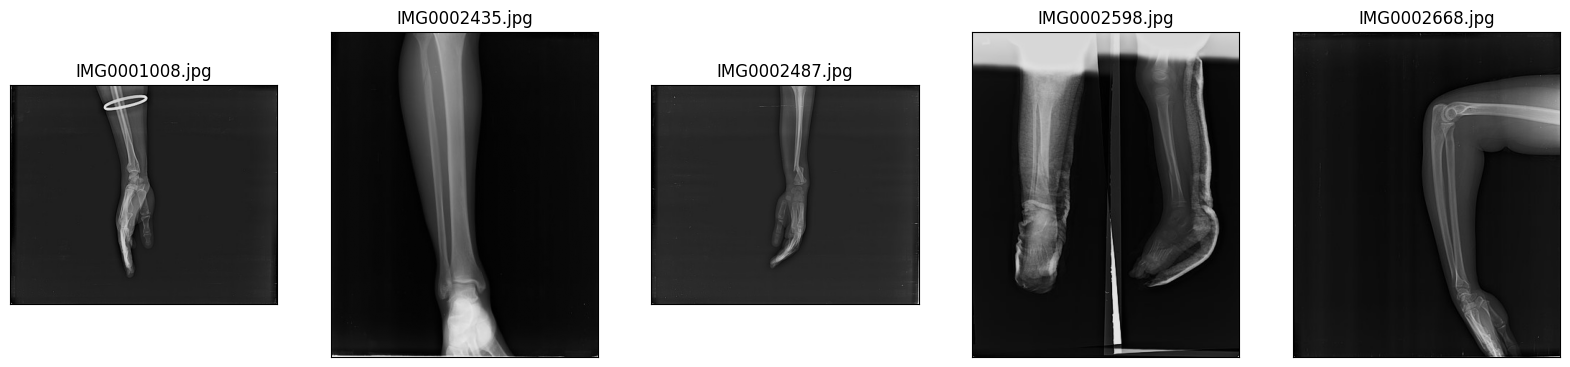

In [4]:
def viewImagesFromDir(path, num=5):
  #Display num random images from dataset. Rerun cell for new random images. The images are only single-channel

  img_paths_visualise = sorted(
        os.path.join(path, fname)
        for fname in os.listdir(path)
        if fname.endswith(".jpg")
  )

  random.shuffle(img_paths_visualise)

  fig, ax = plt.subplots(1, num, figsize=(20, 10))

  for i in range(num):
    ax[i].imshow(Image.open(img_paths_visualise[i]),cmap="gray")
    index = img_paths_visualise[i].rfind('/') + 1
    ax[i].title.set_text(img_paths_visualise[i][index:])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

  fig.canvas.draw()
  time.sleep(1)

viewImagesFromDir(f'{dataset_path}/train/fractured/', num=5)

# Prepare the data

## Configure the hyperparameters

In [4]:
CLASSES = os.listdir(f'/{dataset_path}/train')
TRAINING_DATA_SET_PATH = f'{dataset_path}/train'
VALIDATION_DATA_SET_PATH = f'{dataset_path}/val'
TEST_DATA_SET_PATH = f'{dataset_path}/test'

params = dict(
    seed = 123,
    image_dim = (288,288),
    weight_decay = 1e-4,
    epochs = 50,
    batch_size = 32,
    patch_size = 32,
    pool_size = (2,2),
    optimizer = 'Adam',
    l_rate = 0.001,
    use_data_aug = True,

    l2_reg = .0,
    projection_dim = 64,
    num_heads = 4,

    # Size of the transformer layers
    transformer_layers = 8,
    num_classes = len(CLASSES),
    mlp_head_units = [1024,512]

    )

new_params = dict(
    num_patches = (params['image_dim'][0] // params['patch_size']) ** 2,
    transformer_units = [
    params['projection_dim'] * 2,
    params['projection_dim']],
    input_shape = (params['image_dim'][0], params['image_dim'][1], 3),

)
params.update(new_params)


if params['use_data_aug']:
  data_aug_params = dict(
      da_rotation = 20,
      da_w_shift = 0.1,
      da_h_shift = 0.1,
      da_shear = 0.05,
      da_zoom = 0.05,
      da_h_flip = True,
      da_v_flip = False,
  )

  params.update(data_aug_params)

if params['use_data_aug']:
  datagen = ImageDataGenerator(rescale=1./255,
                               rotation_range=params['da_rotation'],
                               width_shift_range=params['da_w_shift'],
                               height_shift_range=params['da_h_shift'],
                               shear_range=params['da_shear'],
                               zoom_range=params['da_zoom'],
                               horizontal_flip=params['da_h_flip'],
                               vertical_flip=params['da_v_flip'],
                               fill_mode="constant",
                               cval=0
                               )
else:
  datagen = ImageDataGenerator(rescale=1./255)

# Read all training and validation data into variables from directory.
train_generator = datagen.flow_from_directory(TRAINING_DATA_SET_PATH,
                                                    batch_size=params['batch_size'],
                                                    seed=123,
                                                    class_mode="categorical",
                                                    classes=CLASSES,
                                                    target_size=params['image_dim'],
                                                    shuffle=True)


valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(VALIDATION_DATA_SET_PATH,
                                                    batch_size=params['batch_size'],
                                                    seed=123,
                                                    class_mode="categorical",
                                                    classes=CLASSES,
                                                    target_size=params['image_dim'],
                                                    shuffle=True)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_DATA_SET_PATH,
                                                    batch_size=params['batch_size'],
                                                    seed=123,
                                                    class_mode="categorical",
                                                    classes=CLASSES,
                                                    target_size=params['image_dim'],
                                                    shuffle=True)


Found 1148 images belonging to 2 classes.
Found 164 images belonging to 2 classes.
Found 122 images belonging to 2 classes.


## Custom Layers

The following cells uses inspiration from Khalid Salamas and the  [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) paper from Google Research on Vision Transformers.

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]

        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


# Linearly transform patches by projecting it into a
# vector of size `projection_dim` and also adds a learnable position
# embedding to the projected vector.
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Image size: 288 X 288
Patch size: 32 X 32
Patches per image: 81
Elements per patch: 3072


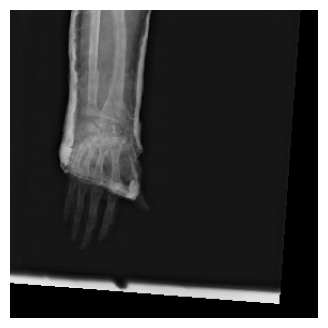

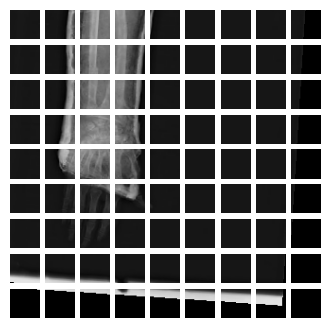

In [ ]:
plt.figure(figsize=(4, 4))
image, label = iter(next(train_generator))
image = image[0]*255.
plt.imshow((image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(params['image_dim'][0], params['image_dim'][0])
)
patches = Patches(params['patch_size'])(resized_image)
print(f"Image size: {params['image_dim'][0]} X {params['image_dim'][0]}")
print(f"Patch size: {params['patch_size']} X {params['patch_size']}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (params['patch_size'], params['patch_size'], 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Generate ViT model

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=params['input_shape'])
    # Create patches.
    patches = Patches(params['patch_size'])(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(params['num_patches'], params['projection_dim'])(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(params['transformer_layers']):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=params['num_heads'], key_dim=params['projection_dim'], dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=params['transformer_units'], dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=params['mlp_head_units'], dropout_rate=0.5)
    # outputs
    output = layers.Dense(len(CLASSES), activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=output)

    return model


## Train Model

In [ ]:
def run_experiment(model):
    optimizer = tf.optimizers.AdamW(
        learning_rate=params['l_rate'], weight_decay=params['weight_decay']
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
           'accuracy',
           tf.keras.metrics.Precision(name="precision"),
          tf.keras.metrics.Recall(name="recall"),
        ],
    )


    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/classification_models/model_best.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1,
        mode="max"
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        verbose=1
    )

    callbacks_list = [checkpoint_callback,
                      tf.keras.callbacks.EarlyStopping(
                          patience=10,
                          monitor="val_accuracy"),
                      reduce_lr]



    history = model.fit(
        train_generator,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=valid_generator,
        callbacks=callbacks_list)

    return history, model

model = create_vit_classifier()
history, model = run_experiment(model)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4612 - loss: 2.9722 - precision: 0.4612 - recall: 0.4612
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/classification_models/model_best.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.4620 - loss: 2.9608 - precision: 0.4620 - recall: 0.4620 - val_accuracy: 0.5000 - val_loss: 1.2223 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.5335 - loss: 1.2636 - precision: 0.5335 - recall: 0.5335
Epoch 2: val_accuracy did not improve from 0.50000
36/36 ━━━━━━━━━━━━━━━━━━━━ 86s 932ms/step - accuracy: 0.5328 - loss: 1.2633 - precision: 0.5328 - recall: 0.5328 - val_accuracy: 0.5000 - val_loss: 0.8555 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.5090 - loss: 0.9817 - precision: 0.5090 - recall: 0.5090
Epoch 

In [12]:
def plot_training_history(history):
    """Plots training history including loss, accuracy, F1-score, recall, and precision."""

    metrics = ["loss", "accuracy", "recall", "precision"]

    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 4))

    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.plot(history.history[metric], label="train")
        ax.plot(history.history[f"val_{metric}"], label="val", linestyle="dashed")
        ax.set_title(metric.replace("_", " ").title())
        ax.set_xlabel("Epochs")
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.legend()

    plt.tight_layout()
    plt.show()

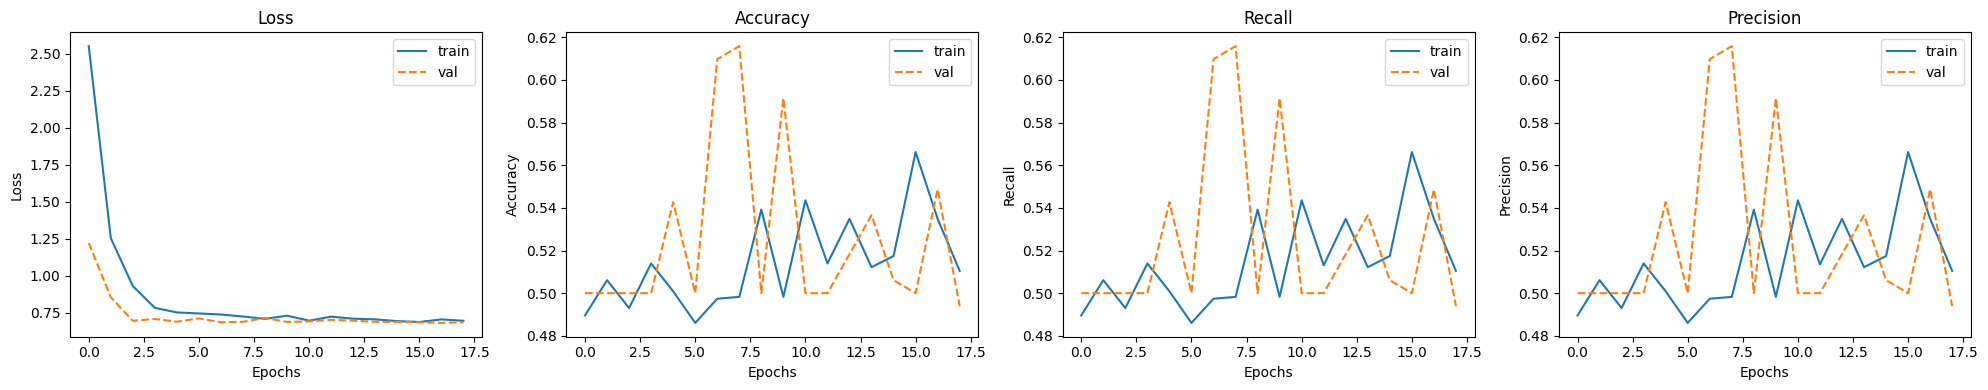

In [ ]:
plot_training_history(history)

## Test Model

In [ ]:
model.evaluate(test_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5444 - loss: 0.6798 - precision: 0.5444 - recall: 0.5444


[0.682671308517456, 0.5327869057655334, 0.5327869057655334, 0.5327869057655334]

# Hyperparameter Tuning

In [6]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.4 MB/s eta 0:00:00


In [7]:
import keras_tuner as kt

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        return self.projection(patch) + self.position_embedding(positions)

# Set up your "HyperModel" to tune model & batch_size
class ViTHyperModel(kt.HyperModel):
    def build(self, hp):
        """
        Build the Vision Transformer model, using certain hyperparameters
        from the tuner (e.g., projection_dim, num_heads, transformer_layers, etc.).
        """
        # hyperparameters to tune:

        hp_patch_size = hp.Choice('patch_size', [16, 32, 64])
        projection_dim = hp.Choice('projection_dim', [32, 64, 128])
        num_heads = hp.Choice('num_heads', [2, 4, 8])
        transformer_layers = hp.Int('transformer_layers', min_value=4, max_value=8, step=2)

        hp_learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

        num_patches = (params['image_dim'][0] // hp_patch_size) ** 2

        # Build your ViT
        inputs = layers.Input(shape=(params['image_dim'][0], params['image_dim'][1], 3))
        patches = Patches(hp_patch_size)(inputs)
        encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

        for _ in range(transformer_layers):
            x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads,
                key_dim=projection_dim,
                dropout=0.1
            )(x1, x1)
            x2 = layers.Add()([attention_output, encoded_patches])
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
            x3 = mlp(x3, hidden_units=[projection_dim * 2, projection_dim], dropout_rate=0.1)
            encoded_patches = layers.Add()([x3, x2])

        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.5)(representation)
        features = mlp(representation, hidden_units=[1024, 512], dropout_rate=0.5)

        outputs = layers.Dense(params['num_classes'], activation='softmax')(features)
        model = tf.keras.Model(inputs, outputs)

        # Compile
        optimizer = tf.optimizers.AdamW(
            learning_rate=hp_learning_rate
        )
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy'
            ],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        """
        Called by Keras Tuner to train 'model' with the chosen hyperparameters.

        Here, we define the batch_size we want to tune,
        and create the data generators with that batch_size.
        """
        # Tune batch_size
        tuned_batch_size = hp.Choice('batch_size', [32, 64, 128, 256])

        # (1) Recreate the data generators with the chosen batch_size
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=params.get('da_rotation', 0),
            width_shift_range=params.get('da_w_shift', 0),
            height_shift_range=params.get('da_h_shift', 0),
            shear_range=params.get('da_shear', 0),
            zoom_range=params.get('da_zoom', 0),
            horizontal_flip=params.get('da_h_flip', False),
            vertical_flip=params.get('da_v_flip', False),
            fill_mode="constant",
            cval=0
        )
        train_generator = train_datagen.flow_from_directory(
            TRAINING_DATA_SET_PATH,
            batch_size=tuned_batch_size,
            seed=params['seed'],
            class_mode="categorical",
            classes=CLASSES,
            target_size=params['image_dim'],
            shuffle=True
        )

        valid_datagen = ImageDataGenerator(rescale=1./255)
        valid_generator = valid_datagen.flow_from_directory(
            VALIDATION_DATA_SET_PATH,
            batch_size=tuned_batch_size,
            seed=params['seed'],
            class_mode="categorical",
            classes=CLASSES,
            target_size=params['image_dim'],
            shuffle=True
        )

        # (2) Fit the model as usual, but with our newly-created generators
        return model.fit(
            train_generator,
            validation_data=valid_generator,
            epochs=kwargs.get("epochs", 10),  # or pass epochs from tuner.search
            callbacks=kwargs.get("callbacks", None),
            verbose=kwargs.get("verbose", 1)
        )

# Instantiate and run the Tuner
def tune_vit_model():
    tuner = kt.RandomSearch(
        hypermodel=ViTHyperModel(),
        objective='val_accuracy',
        max_trials=30,          # how many hyperparam sets to try
        executions_per_trial=1, # how many times to train each set
        directory='/content/drive/MyDrive/vit_batch_tuner',
        project_name='xray_fracture'
    )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

    tuner.search(
        epochs=15,  # fewer epochs for tuning
        callbacks=[stop_early],
        verbose=1   # show the logs
    )

    # Retrieve best results
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameter combination:", best_hp.values)

    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model, best_hp

best_model, best_hp = tune_vit_model()
best_model.save("/content/drive/MyDrive/classification_models/best_vit_tuner_model.keras")
best_model.summary()

Trial 30 Complete [00h 07m 14s]
val_accuracy: 0.5365853905677795

Best val_accuracy So Far: 0.6219512224197388
Total elapsed time: 23h 23m 35s
Best hyperparameter combination: {'patch_size': 32, 'projection_dim': 32, 'num_heads': 8, 'transformer_layers': 8, 'lr': 0.00048690017276281297, 'batch_size': 128}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 280 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 288, 288, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches (Patches)         │ (None, None, 3072)     │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder             │ (None, 81, 32)         │        100,928 │ patches[0][0]          │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 81, 32)         │             64 │ patch_encoder[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 81, 32)         │         33,568 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 81, 32)         │              0 │ multi_head_attention[… │
│                           │                        │                │ patch_encoder[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 81, 32)         │             64 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 81, 64)         │          2,112 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 81, 64)         │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 81, 32)         │          2,080 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 81, 32)         │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 81, 32)         │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 81, 32)         │             64 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 81, 32)         │         33,568 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 81, 32)         │              0 │ multi_head_attention_… │
│                           │                        │                │ add_1[0][0]            │
├──────────────────────

 Total params: 3,585,154 (13.68 MB)

 Trainable params: 3,585,154 (13.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_params = best_hp.values

with open("best_hyperparams.json", "w") as f:
    json.dump(best_params, f, indent=2)

In [ ]:
print("Best HP:", best_hp.values)

## Train best model

In [10]:
# fine-tune the best model for a longer period:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=params['da_rotation'],
    width_shift_range=params['da_w_shift'],
    height_shift_range=params['da_h_shift'],
    shear_range=params['da_shear'],
    zoom_range=params['da_zoom'],
    horizontal_flip=params['da_h_flip'],
    vertical_flip=params['da_v_flip'],
    fill_mode="constant",
    cval=0
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# get the best batch size
bs = best_hp.get('batch_size')

# create the generators
train_generator = train_aug.flow_from_directory(
    TRAINING_DATA_SET_PATH,
    batch_size=bs,
    target_size=params['image_dim'],
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    VALIDATION_DATA_SET_PATH,
    batch_size=bs,
    target_size=params['image_dim'],
    class_mode='categorical',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DATA_SET_PATH,
    batch_size=bs,
    target_size=params['image_dim'],
    class_mode='categorical',
    shuffle=True
)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/classification_models/vit_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
    mode="max"
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    verbose=1
)

callbacks_list = [checkpoint_callback,
                  tf.keras.callbacks.EarlyStopping(
                      patience=10,
                      monitor="val_accuracy"),
                  reduce_lr]

# fit the best model for more epochs
history = best_model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    callbacks=callbacks_list,
    verbose=1
)

Found 1148 images belonging to 2 classes.
Found 164 images belonging to 2 classes.
Found 122 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5148 - loss: 0.7112
Epoch 1: val_accuracy improved from -inf to 0.53049, saving model to /content/drive/MyDrive/classification_models/vit_best.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.5154 - loss: 0.7110 - val_accuracy: 0.5305 - val_loss: 0.6918 - learning_rate: 4.8690e-04
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5127 - loss: 0.7035
Epoch 2: val_accuracy did not improve from 0.53049
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.5148 - loss: 0.7030 - val_accuracy: 0.5122 - val_loss: 0.6957 - learning_rate: 4.8690e-04
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5749 - loss: 0.6874
Epoch 3: val_accuracy improved from 0.53049 to 0.54878, saving model to /content/drive/MyDrive/classification_models/vit_best.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.5728 - loss: 0.6884 - val_accuracy: 0.5488 - val_loss: 0.6929 - learning_rate: 4.8690e-04
Epoch 4/100
9/9 ━━━

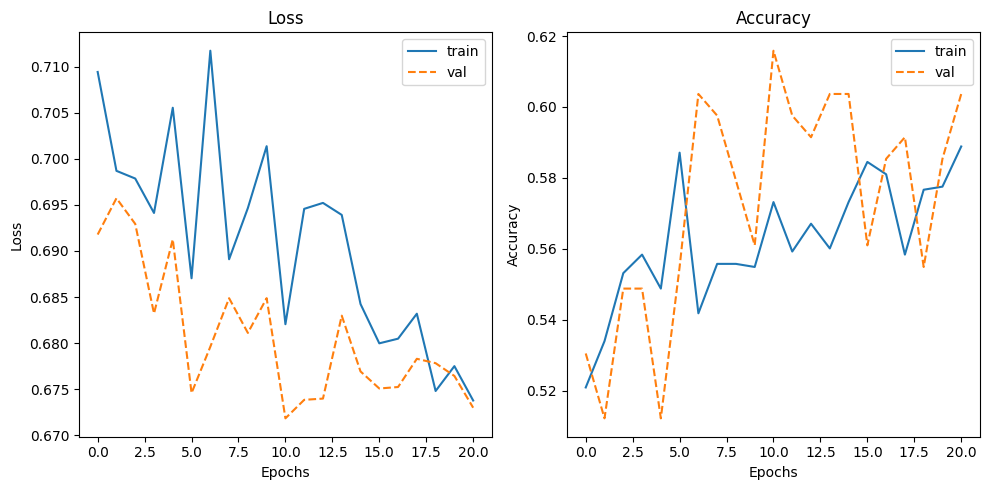

In [15]:
metrics = ["loss", "accuracy"]

fig, axes = plt.subplots(1, len(metrics), figsize=(10, 5))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric], label="train")
    ax.plot(history.history[f"val_{metric}"], label="val", linestyle="dashed")
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metric.replace("_", " ").title())
    ax.legend()

plt.tight_layout()
plt.show()

## Evaluate model

In [18]:
loss, acc = best_model.evaluate(test_generator)
print(f"Test accuracy: {acc*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5738 - loss: 0.6727
Test accuracy: 57.38%
